# **Deep Learning — Introduction to Generative Adversarial Network(GAN)**
How human being masters any skill?

- Firstly, he learns the skill, get feedback on what is still missing. Then, relearn the missing skill, unlearn things that are not contributing towards the skill. Get feedback. Repeat this cycle till you have mastered the skill.

This is exactly how GAN’s work.

# **What is Generative Adversarial Network(GAN)?**
* GAN is a deep learning, unsupervised machine learning technique proposed by Ian Goodfellow and few other researchers including Yoshua Bengio in 2014.

* GAN composes of two deep networks: the generator and the discriminator. Both of them simultaneously trained. Generally, the model structure and training process operates simultaneously.

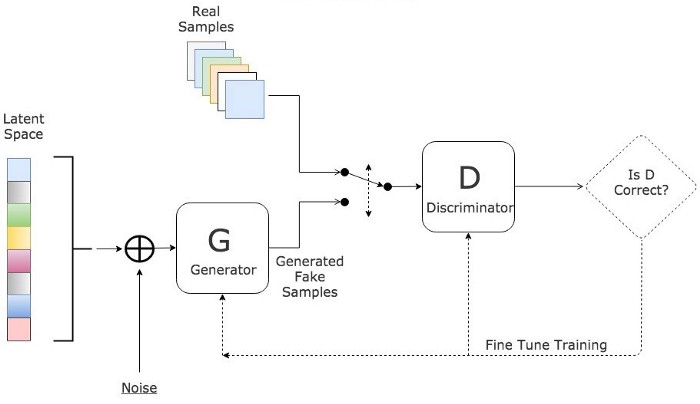

* In GAN we have a Generator that is pitted against an adversarial network called Discriminator. Hence the name Generative Adversarial Network

* Both Generator and Discriminator are multilayer perceptrons (MLP).

* Generator’s objective is to model or generate data that is very similar to the training data. Generator needs to generate data that is indistinguishable from the real data. Generated data should be such that discriminator is tricked to identify it as real data.

* Discriminator objective is to identify if the data is real or fake. It gets two sets of input. One input comes from the training dataset and the other input is the modelled dataset generated by Generator.

* Generator can be thought as team of counterfeiters making fake currency which looks exactly like real currency. Discriminators can be considered as team of cops trying to detect the counterfeit currency. Counterfeiters and cops both are trying to beat each other at their game.

* GAN do not need any approximate inference or markov chains.
* Recent architectures such as StyleGAN 2 can produce outstanding photo-realistic images.

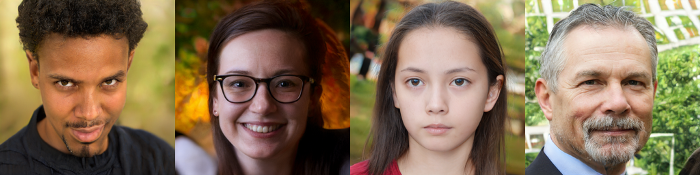

Hand-picked examples of human faces generated by StyleGAN 2, Source arXiv:1912.04958v2

# **How does GAN work?**

**Generator G(z)**

Input to the Generator is random noise created from the training data. Training data can be an image. Generator tries to mimic the input image as close as possible to the real image from the training data. Generator’s goal is to to fool the Discriminator.

**Discriminator D(x)**

Discriminator gets two inputs. One is the real data from training dataset and other is the fake data from the Generator. Goal of the Discriminator is to identify which input is real and which is fake.

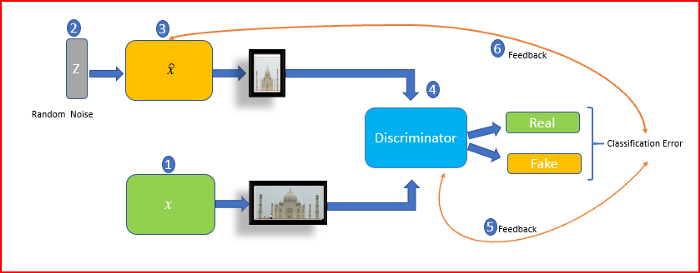

Basic GAN follows the following steps: 
* Step 1: Train the Discriminator using the training data, x. Objective of Discriminator to maximize the probability of getting correct label. Output should be real for the training data and fake for data generated from the Generator.
* Step 2: Take a random input from the training data and introduce noise to create random noise data z.
*  Step 3:Generator takes the random noise data z and tries to reconstruct the input x hat.
* Step 4: Discriminator takes input from two sources. One input is the real input from the training data. Other input is the data generated by the Generator. Discriminator classifies input as real or fake. Based on classification, classification error is computed.
* Step 5: We then back propagate the classification error to update the Discriminator. Objective of Discriminator is to minimize the classification error.
* Step 6: Classification error is also back propagated to update the Generator. Objective of the Generator is to to maximize the Discriminator classification error.

Generator G generates a probability Pg as distribution of the samples G(z) obtained from z.

To learn the generator’s distribution Pg over data x, we define a prior on input noise variables Pz(z),
D(x) represents the probability from the training data x rather than Pg.

GAN’s need to optimize the minimax objective function.

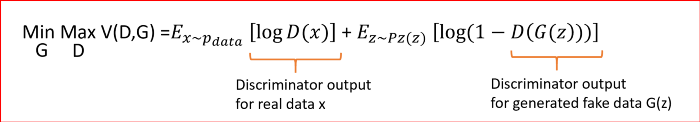

Early in the training Discriminator will reject generated fake data from Generator with high confidence. Initially fake data would be different from the training data.

As we train Discriminator to maximize the probability of assigning the correct labels to both training examples and samples from Generator. We simultaneously train Generator to minimize the Discriminator classification error for the generated fake data.

Discriminator wants to maximize objective such that D(x) is close to 1 for real data and D(G(z)) is close to 0 for fake data.

Generator wants to minimize objective such that D(G(z)) is close to 1 so that the discriminator is fooled into thinking generated G(z) is real.

We stop the training when the fake data generated by the Generator is recognized as the real data.

**Usage of GAN**

* Generating a high resolution image from a low resolution image
* Generating a fine image from a coarse image
* Generate descriptions based on images

# Basic GAN Source Code using MNIST Dataset

In [1]:
# # reference:
# https://medium.datadriveninvestor.com/deep-learning-generative-adversarial-network-gan-34abb43c0644
# https://towardsdatascience.com/review-of-gans-for-tabular-data-a30a2199342
# https://github.com/channel-learnings/Basic-GAN/blob/master/GAN%20on%20mnist.ipynb

In [2]:
#import packages
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Data Loader for MNIST
mb_size = 64
transform = transforms.ToTensor()
trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#labeling the image
dataIter = iter(trainLoader)
imgs, labels = dataIter.next()
imgs.shape

torch.Size([64, 1, 28, 28])

In [5]:
#define image show method
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

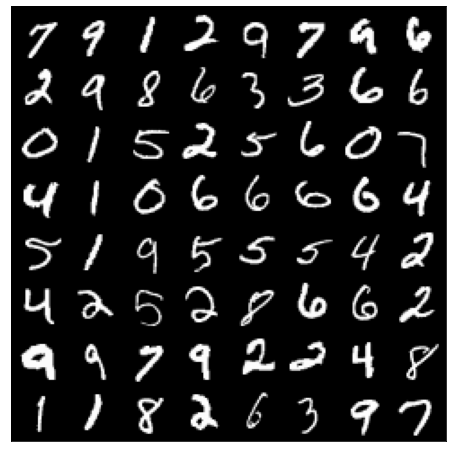

In [6]:
imshow(imgs)

In [7]:
#reset image dimensions 
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cpu' # set cuda for GPU

100 128 784


In [8]:
#define Generator class
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
          
    def forward(self, input):
      return self.model(input)

In [9]:
G = Gen().to(device)

In [10]:
# define Discriminator class
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

In [11]:
D = Dis().to(device)

In [12]:
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [13]:
# define optimizer for G(z) and D(x)
lr = 1e-3
g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:4.833170415368924,    D_loss:0.13798640523878322


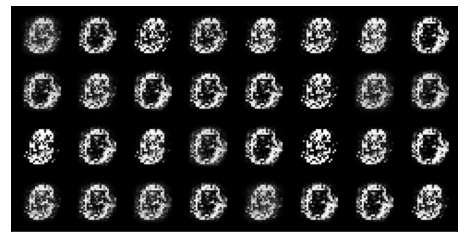

Epoch:1,   G_loss:4.025849959743557,    D_loss:0.1151888297755581


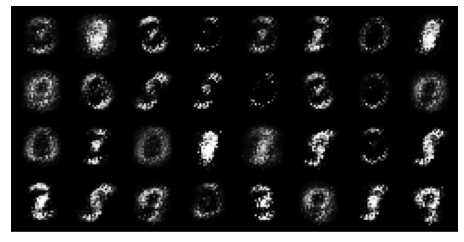

Epoch:2,   G_loss:3.8602948653926727,    D_loss:0.24734882774478845


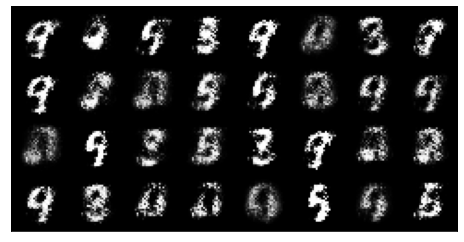

Epoch:3,   G_loss:3.6133746831401834,    D_loss:0.3808198693369243


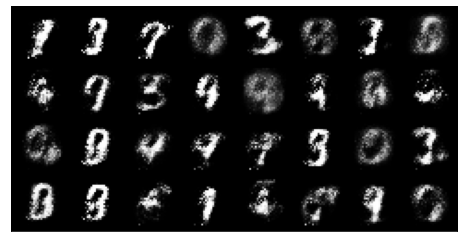

Epoch:4,   G_loss:3.330916891601294,    D_loss:0.5045176041183441


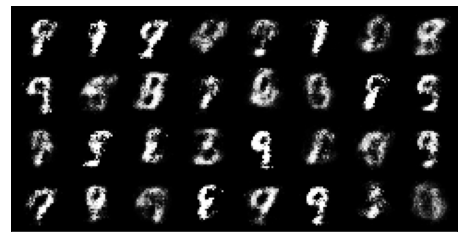

Epoch:5,   G_loss:2.9805898319429427,    D_loss:0.6585617329297798


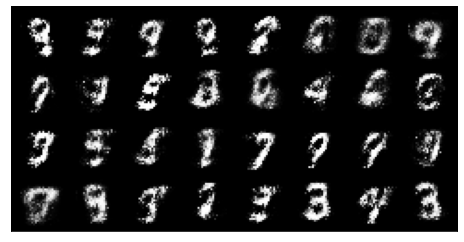

Epoch:6,   G_loss:2.960162142700732,    D_loss:0.7921545650404908


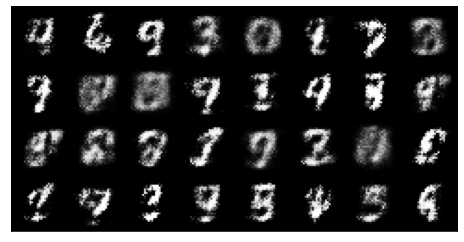

Epoch:7,   G_loss:2.735315281063763,    D_loss:0.860165925581318


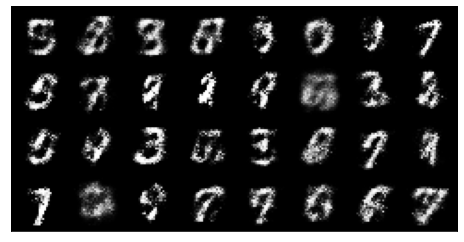

Epoch:8,   G_loss:2.5201572609354437,    D_loss:0.8878802389287745


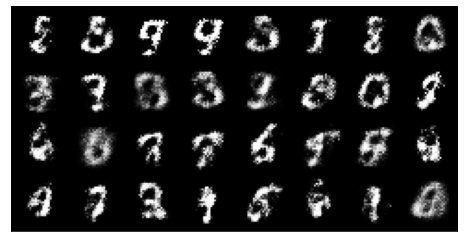

Epoch:9,   G_loss:2.206074414476911,    D_loss:0.9382570222941543


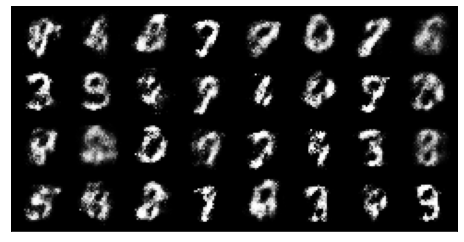

Epoch:10,   G_loss:2.0918482815278874,    D_loss:0.9683052343346162


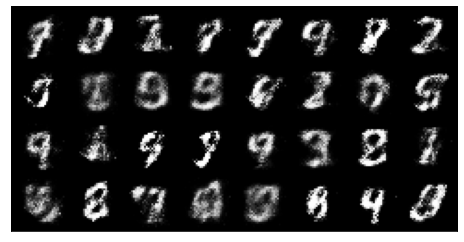

Epoch:11,   G_loss:2.1268100040807907,    D_loss:0.9765624194257041


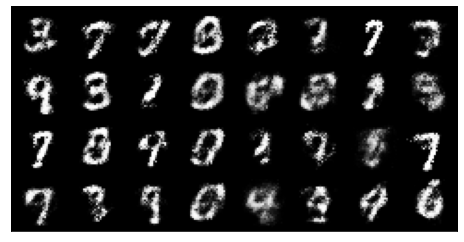

Epoch:12,   G_loss:1.9456139469960096,    D_loss:0.9720336146700357


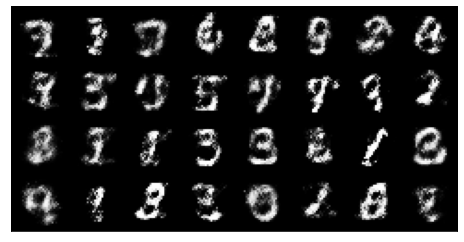

Epoch:13,   G_loss:1.9326115551787908,    D_loss:0.9379192837901207


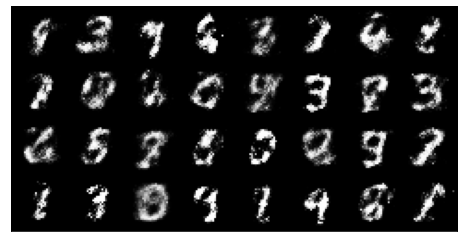

Epoch:14,   G_loss:1.866183212952319,    D_loss:1.0061331764340147


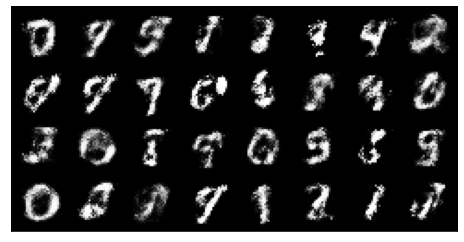

Epoch:15,   G_loss:1.8220489871527341,    D_loss:0.9475155759340664


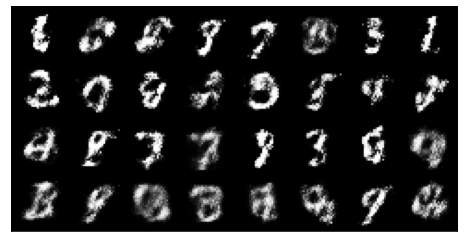

Epoch:16,   G_loss:1.857957667252148,    D_loss:0.9480323672040439


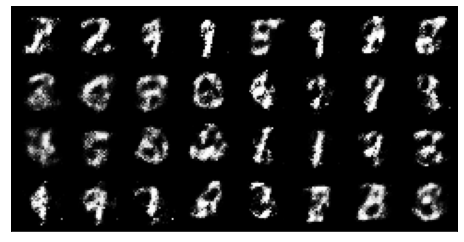

Epoch:17,   G_loss:1.7791126314510923,    D_loss:0.9702466031762836


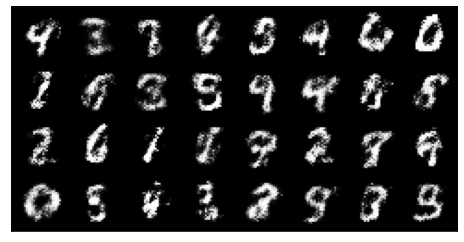

Epoch:18,   G_loss:1.8145627731453382,    D_loss:0.9504280887178774


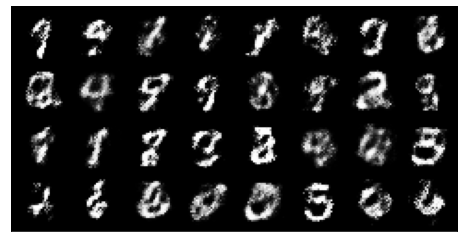

Epoch:19,   G_loss:1.8176178609384404,    D_loss:0.9658283827655605


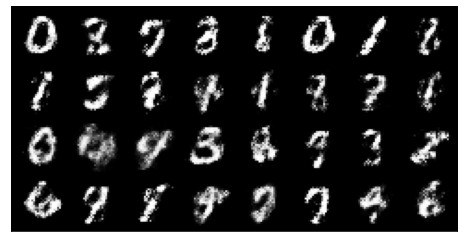

In [14]:
# Run GAN training for 20 epoch 
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.view(X.size(0), -1).to(device)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)
        
        z = torch.randn(mb_size, Z_dim).to(device)
        
        D_real = D(X)
        D_fake = D(G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(mb_size, Z_dim).to(device)
        D_fake = D(G(z))
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)